In [1]:
import numpy as np

from triqs.gf import *
from triqs.operators import *
from triqs.operators.util.hamiltonians import h_int_slater
from triqs.operators.util import *
from triqs.operators.util.hamiltonians import *

from triqs.atom_diag import *
import numpy as np
from itertools import product
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm
from scipy.signal import find_peaks


from gwsolver import GWSolver, GWSolverDLR

import re
from IPython.display import display, Markdown

In [2]:
def number_of_particles(g_w):
    return g_w.total_density().real

def number_of_particles_DLR(g_w):
    g_dlr = make_gf_dlr(g_w)
    rho = g_dlr.density()
    N = 0
    for name, g in g_w:
        N += np.sum(np.diag(rho[name].data)).real
    return N

def dyson(g0_w, mu):
    g_w = g0_w.copy()
    for name, g in g0_w:
        g_w[name] = (g0_w[name].inverse() - mu).inverse()
    return g_w

def fix_particle_number(g, N, eps = 1e-3):
    g_w = g.copy()
    step = 1.0

    particle_number = number_of_particles(g_w)

    while abs(particle_number - N) > eps:
        # print(particle_number)
        if particle_number - N > 0:
            g_w = dyson(g_w, step)
        elif particle_number - N < 0:
            g_w = dyson(g_w, -step)
        step = 0.99 * step
        particle_number = number_of_particles(g_w)

    return g_w

def number_of_particles_from_ad(H, fundamental_operators, number_operator, beta, mu):
    Hmu = H + mu * number_operator
    atomic_diagonal = AtomDiagComplex(Hmu, fundamental_operators)
    density_matrix = atomic_density_matrix(atomic_diagonal, beta)
    filling = trace_rho_op(density_matrix, number_operator, atomic_diagonal)
    return filling.real, atomic_diagonal

def fix_atomic_diag(H, fundamental_operators, target_occupation, number_operator, beta, mu = None, eps = 1e-6):
    if mu is None:
        mu = 0

    step = 1.0

    occupation, atomic_diagonal = number_of_particles_from_ad(H, fundamental_operators, number_operator, beta, mu)

    previous_direction = None
    iterator = 0
    while abs(occupation - target_occupation) > eps:
        if occupation - target_occupation > 0:
            if previous_direction == 'decrement':
                step /= 2
            previous_direction = 'increment'
            mu += step
        if occupation - target_occupation < 0:
            if previous_direction == 'increment':
                step /= 2
            previous_direction = 'decrement'
            mu -= step
        occupation, atomic_diagonal = number_of_particles_from_ad(H, fundamental_operators, number_operator, beta, mu)
        iterator += 1
        # print(f"ED Iteration {iterator}: mu = {mu}, N = {occupation}", end='\r')
    return atomic_diagonal, mu

def exact_diag(tij, V, occupation = None, beta = 100, nw = 1 * 1024):
    spin_names = ['up', 'dn']
    orbital_names = range(len(tij))

    if occupation is None:
        occupation = len(tij)

    fundamental_operators = [(spin_name, orbital_name) for spin_name, orbital_name in product(spin_names, orbital_names)]

    N = 0
    for i in orbital_names:
        N += n('up', i) + n('dn', i)

    H = h_int_slater(spin_names, len(orbital_names), V, off_diag = True, complex = True)
        
    for spin, i, j in product(spin_names, orbital_names, orbital_names):
        H += tij[i, j] * c_dag(spin, i) * c(spin, j)
        
    atomic_diagonal, mu = fix_atomic_diag(H, fundamental_operators, occupation, N, beta)

    gf_struct = [('dn', len(orbital_names)),
                ('up', len(orbital_names))]

    G_w = atomic_g_iw(atomic_diagonal, beta, gf_struct, nw)
    return G_w

def generate_g0_w(tij, mesh, spin_names = ['up', 'dn']):
    g_inv = Gf(mesh = mesh, target_shape = np.shape(tij))
    g_inv << iOmega_n - tij.transpose()
    g = g_inv.inverse()
    return BlockGf(block_list = [g] * 2, name_list = spin_names)

def GWsolve(tij, V, mesh, occupation = None, spin_names = ['up', 'dn']):
    if occupation is None:
        occupation = len(tij)
        
    g0_w = generate_g0_w(tij, mesh, spin_names)
    gw = GWSolver(g0_w, V, self_interactions = True, hartree_flag = True, fock_flag = True, N_fix = occupation)
    return gw.g_w

def GWsolveDLR(tij, V, occupation = None, beta = 50, spin_names = ['up', 'dn']):
    if occupation is None:
        occupation = len(tij)

    mesh = MeshDLRImFreq(beta = beta, statistic = 'Fermion', w_max = 5, eps = 1e-15)
    g0_w = generate_g0_w(tij, mesh, spin_names)
    gw = GWSolverDLR(g0_w, V, self_interactions = True, hartree_flag = True, fock_flag = True, N_fix = occupation)
    return gw.g_w

def CoulombPrint(V):
    spin_names = ['up', 'dn']
    orbitals = np.shape(V)[0]
    V = str(h_int_slater(spin_names, orbitals, V, off_diag = True, complex = True))
    operators = r"c(?:_dag)?\('(?:dn|up)',(\d+)\)"
    reformatted = re.sub(operators, lambda x: f"c_{{{x.group(1)},\\{'downarrow' if x.group(0).find('dn') != -1 else 'uparrow'}}}^\\dagger" if '_dag' in x.group(0) else f"c_{{{x.group(1)},\\{'downarrow' if x.group(0).find('dn') != -1 else 'uparrow'}}}", V)
    reformatted = reformatted.replace('*', ' ')
    display(Markdown('$\hat{V} = ' + reformatted + '$'))
    

In [3]:
def construct_coulomb_matrix(orbitals, U, non_local = False):
    Vij = np.zeros([orbitals] * 2)
    for i in range(orbitals):
        for j in range(orbitals):
            Vij[i, j] = round(U / (abs(i - j) + 1), 2)
    
    if non_local:
        return Vij
    return np.diag(Vij.diagonal())

def construct_coulomb_tensor(orbitals, U, non_local = False):
    Vij = construct_coulomb_matrix(orbitals, U, non_local)
    Vijkl = np.zeros([orbitals] * 4)
    for i in range(orbitals):
        for j in range(orbitals):
            Vijkl[i, j, i, j] = Vij[i, j]
    return Vijkl

def greensfunctions(orbitals, occupation, U, non_local = False, printV = False, DLR = True, beta = 1, nw = 5 * 1024):
    print(f"DLR: {DLR}")
   
    t = 1.0
    # U = t / ratio

    Vij = construct_coulomb_matrix(orbitals, U, non_local)

    Vijkl = construct_coulomb_tensor(orbitals, U, non_local)
    if printV:
        CoulombPrint(Vijkl)

    tij = np.zeros([orbitals] * 2)
    for i in range(orbitals - 1):
        tij[i, i + 1] = -t
        tij[i + 1, i] = -t

    G_w = exact_diag(tij, Vijkl, occupation = occupation, beta = beta, nw = nw)
    if DLR:
        g_w = GWsolveDLR(tij, Vij, occupation = occupation, beta = beta)
        return G_w, g_w
    g_w = GWsolve(tij, Vij, G_w.mesh, occupation = occupation)
    return G_w, g_w  

def spectral(g_w):
    A = 0
    for name, g in g_w:
        A += -np.imag(np.trace(g.data[:, :, :], axis1 = 1, axis2 = 2))
    return A

def interactions(orbitals, occupation = None, non_local = False, pade = False):

    if occupation is None:
        occupation = orbitals

    ratios = [3, 2, 1.1, 0.9]


    fig, axs = plt.subplots(1, len(ratios), figsize = (5 * len(ratios), 5), facecolor = 'black')

    for i, ratio in enumerate(ratios):
        G_iw, g_iw_dlr = greensfunctions(orbitals, occupation, 1 / ratio, non_local)
        if pade:
            g_dlr = make_gf_dlr(g_iw_dlr)
            w_mesh = MeshReFreq(window = (-15, 15), n_w = 1 * 2048)
            g_iw = make_gf_imfreq(g_dlr, n_iw = 1 * 2048)

            G_w_temp = Gf(mesh = w_mesh, target_shape = [orbitals, orbitals])
            G_w = BlockGf(block_list = [G_w_temp] * 2, name_list = ['up', 'dn'])
            for block, g in G_w:
                G_w[block].set_from_pade(G_iw[block], n_points = 100, freq_offset = 0.1)

            g_w_temp = Gf(mesh = w_mesh, target_shape = [orbitals, orbitals])
            g_w = BlockGf(block_list = [g_w_temp] * 2, name_list = ['up', 'dn'])
            for block, g in G_w:
                g_w[block].set_from_pade(g_iw[block], n_points = 100, freq_offset = 0.1)

            wG = [iw for iw in G_w.mesh.values()]
            wg = [iw for iw in g_w.mesh.values()]
        else:
            G_w = G_iw.copy()
            g_w = g_iw_dlr.copy()
            wG = [iw.imag for iw in G_w.mesh.values()]
            wg = [iw.imag for iw in g_w.mesh.values()]

        
        axs[i].set_facecolor('black')
        axs[i].xaxis.label.set_color('white')
        axs[i].tick_params(axis = 'x', colors = 'white')
        axs[i].yaxis.label.set_color('white')
        axs[i].tick_params(axis = 'y', colors = 'white')

        axs[i].set_xlim(-10, 10)
        if pade:
            axs[i].set_xlim(-2, 2)
        axs[i].set_title("t / U = {}".format(ratio), color = 'white', fontsize = 25)

        axs[i].plot(wG, spectral(G_w), color = 'white', zorder = 0)
        axs[i].scatter(wg, spectral(g_w), color = 'red', zorder = 1)

        axs[i].text(0.25, 0.9, "#G_w = {:.2f}".format(number_of_particles(G_iw)), horizontalalignment = 'center', verticalalignment = 'center', transform = axs[i].transAxes, fontsize = 15, color = 'white')
        axs[i].text(0.25, 0.8, "#g_w = {:.2f}".format(number_of_particles_DLR(g_iw_dlr)), horizontalalignment = 'center', verticalalignment = 'center', transform = axs[i].transAxes, fontsize = 15, color = 'white')
    plt.show()
    return

def GWtoED(orbitals, occupation, U, beta = 20, nw = 1024, non_local = False, pade = False):
    G_iw, g_iw = greensfunctions(orbitals, occupation, U, non_local, False, False, beta, nw)
    wf = [w.imag for w in G_iw.mesh.values()]
    w_dlr = [iw.imag for iw in g_iw.mesh.values()]
    print(np.max(w_dlr))

    if not pade:
        fig, axs = plt.subplots(orbitals, orbitals, figsize = (7 * orbitals, 7 * orbitals), facecolor = 'black')
        s = 8

        for i in range(orbitals):
            for j in range(orbitals):
                axs[i, j].set_facecolor('black')
                axs[i, j].xaxis.label.set_color('white')
                axs[i, j].tick_params(axis = 'x', colors = 'white')
                axs[i, j].yaxis.label.set_color('white')
                axs[i, j].tick_params(axis = 'y', colors = 'white')
                axs[i, j].set_xlim(-10, 10)
                # axs[i, j].set_ylim(-5, 5)


                axs[i, j].plot(wf, G_iw['dn'].data[:, i, j].real, color = 'white', zorder = 0)
                axs[i, j].plot(wf, G_iw['dn'].data[:, i, j].imag, color = 'white', zorder = 0)

                axs[i, j].scatter(w_dlr, g_iw['dn'].data[:, i, j].real, color = 'red', s = s, zorder = 1)
                axs[i, j].scatter(w_dlr, g_iw['dn'].data[:, i, j].imag, color = 'blue', s = s, zorder = 1)
        plt.show()
        return

    g_dlr = make_gf_dlr(g_iw)
    w_mesh = MeshReFreq(window = (-15, 15), n_w = 2 * 2048)
    g_iw = make_gf_imfreq(g_dlr, n_iw = 2 * 2048)

    G_w_temp = Gf(mesh = w_mesh, target_shape = [orbitals, orbitals])
    G_w = BlockGf(block_list = [G_w_temp] * 2, name_list = ['up', 'dn'])
    for block, g in G_w:
        G_w[block].set_from_pade(G_iw[block], n_points = 100, freq_offset = 0.1)

    g_w_temp = Gf(mesh = w_mesh, target_shape = [orbitals, orbitals])
    g_w = BlockGf(block_list = [g_w_temp] * 2, name_list = ['up', 'dn'])
    for block, g in G_w:
        g_w[block].set_from_pade(g_iw[block], n_points = 100, freq_offset = 0.1)


    fig, ax = plt.subplots(1, figsize = (12, 12), facecolor = 'black')

    ax.set_facecolor('black')
    ax.xaxis.label.set_color('white')
    ax.tick_params(axis = 'x', colors = 'white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis = 'y', colors = 'white')
    ax.set_xlim(-5, 5)

    ax.plot([w for w in G_w.mesh.values()], spectral(G_w), color = 'white', zorder = 0)
    ax.scatter([w for w in g_w.mesh.values()], spectral(g_w), color = 'red', s = 3, zorder = 1)
    plt.show()
    return

def relativeErrors(orbitals, occupation, U, beta = 20, nw = 1024, non_local = False):
    G_iw, g_iw = greensfunctions(orbitals, occupation, U, non_local, False, False, beta, nw)
    wf = [w.imag for w in G_iw.mesh.values()]


    fig, axs = plt.subplots(orbitals, orbitals, figsize = (7 * orbitals, 7 * orbitals), facecolor = 'black')
    s = 8

    for i in range(orbitals):
        for j in range(orbitals):
            axs[i, j].set_facecolor('black')
            axs[i, j].xaxis.label.set_color('white')
            axs[i, j].tick_params(axis = 'x', colors = 'white')
            axs[i, j].yaxis.label.set_color('white')
            axs[i, j].tick_params(axis = 'y', colors = 'white')
            axs[i, j].set_xlim(-5, 5)
            # axs[i, j].set_ylim(-5, 5)


            axs[i, j].plot(wf, (G_iw['up'].data[:, i, j].real - g_iw['up'].data[:, i, j].real) / G_iw['up'].data[:, i, j].real, color = 'red', zorder = 0)
            axs[i, j].plot(wf, (G_iw['up'].data[:, i, j].imag - g_iw['up'].data[:, i, j].imag) / G_iw['up'].data[:, i, j].imag, color = 'blue', zorder = 0)

            # axs[i, j].scatter(w_dlr, g_iw['up'].data[:, i, j].real, color = 'red', s = s, zorder = 1)
            # axs[i, j].scatter(w_dlr, g_iw['up'].data[:, i, j].imag, color = 'blue', s = s, zorder = 1)
    plt.show()
    return

def GWplot(orbitals, occupation, ratio, plot = True, beta = 100, nw = 1 * 1024, non_local = False):
    if occupation is None:
        occupation = orbitals
        
    t = 1.0
    U = t / ratio

    Vij = construct_coulomb_matrix(orbitals, U, non_local)
    # Vijkl = construct_coulomb_tensor(orbitals, U, non_local)
    # CoulombPrint(Vijkl)

    tij = np.zeros([orbitals] * 2)
    for i in range(orbitals - 1):
        tij[i, i + 1] = t
        tij[i + 1, i] = t

    # mesh = MeshImFreq(beta, 'Fermion', nw)
    g_iw = GWsolveDLR(tij, Vij, occupation = occupation)

    if plot:
        wf = [w.imag for w in g_iw.mesh.values()]


        fig, axs = plt.subplots(orbitals, orbitals, figsize = (7 * orbitals, 7 * orbitals), facecolor = 'black')
        
        for i in range(orbitals):
            for j in range(orbitals):
                axs[i, j].set_facecolor('black')
                axs[i, j].xaxis.label.set_color('white')
                axs[i, j].tick_params(axis = 'x', colors = 'white')
                axs[i, j].yaxis.label.set_color('white')
                axs[i, j].tick_params(axis = 'y', colors = 'white')
                axs[i, j].set_xlim(-5, 5)

                axs[i, j].plot(wf, g_iw['up'].data[:, i, j].real, color = 'red', linewidth = 2, zorder = 1)
                axs[i, j].plot(wf, g_iw['up'].data[:, i, j].imag, color = 'blue', linewidth = 2, zorder = 1)

def symmetric_difference(omega, value, A):
    w_index = np.argmin(np.abs(omega - value))

    left_sum = np.sum(A[:w_index])
    right_sum = np.sum(A[w_index:])
    return left_sum - right_sum

def find_center_freq(g):
    omega = np.array([w for w in g.mesh.values()])
    A = spectral(g)

    w_step = 5.0

    w = 0
    difference = symmetric_difference(omega, w, A)
    last_difference = 2 * difference

    previous_direction = None
    iter = 0
    while abs(difference) > 0.0001:
        if abs(difference - last_difference) < 1e-6:
            break

        iter += 1
        if difference < 0:
            if previous_direction == 'decrement':
                w_step /= 2
            previous_direction = 'increment'
            w += w_step
        else:
            if previous_direction == 'increment':
                w_step /= 2
            previous_direction = 'decrement'
            w -= w_step

        last_difference = difference
        difference = symmetric_difference(omega, w, A)
        # print(f"Iteration = {iter}, w = {w}, difference = {difference}", end='\r')
    
    return w

def colorPlot(orbitals, occupation, non_local = True, beta = 100, nw = 1 * 1024):

    def offset(g_w, w, w_center_arg):
        return np.argmin(np.abs(w - find_center_freq(g_w))) - w_center_arg
    
    def flag_solve(H, F, GW, Vij, g0_w, w_mesh, w, w_center_arg):
        g_w_temp = Gf(mesh = w_mesh, target_shape = [orbitals, orbitals])
        gw = GWSolver(g0_w, Vij, self_interactions = True, hartree_flag = H, fock_flag = F, gw_flag = GW, N_fix = occupation)
        g_iw  = gw.g_w

        g_w = BlockGf(block_list = [g_w_temp] * 2, name_list = ['up', 'dn'])
        for block, g in g_w:
            g_w[block].set_from_pade(g_iw[block], n_points = 100, freq_offset = 0.1)

        g_w_offset = offset(g_w, w, w_center_arg)
        return spectral(g_w)[w_min_arg + g_w_offset:w_max_arg + g_w_offset]
    
    HFGW = []
    HF = []
    H = []
    HGW = []
    FGW = []
    GW = []
    F = []

    Aed = []
    w_mesh = MeshReFreq(window = (-15, 15), n_w = 1 * 2048)

    w = np.array([W for W in w_mesh.values()])

    w_min = -5
    w_max = -w_min

    w_min_arg = np.argmin(np.abs(w - w_min))
    w_max_arg = np.argmin(np.abs(w - w_max))
    w_center_arg = np.argmin(np.abs(w))

    U_list = np.linspace(0, 1.5, 32)
    for U in U_list:
        t = 1.0

        Vij = construct_coulomb_matrix(orbitals, U, non_local)
        Vijkl = construct_coulomb_tensor(orbitals, U, non_local)

        tij = np.zeros([orbitals] * 2)
        for i in range(orbitals - 1):
            tij[i, i + 1] = -t
            tij[i + 1, i] = -t

        g_w_temp = Gf(mesh = w_mesh, target_shape = [orbitals, orbitals])
        G_iw = exact_diag(tij, Vijkl, occupation = occupation, beta = beta)
        G_w = BlockGf(block_list = [g_w_temp] * 2, name_list = ['up', 'dn'])
        for block, g in G_w:
            G_w[block].set_from_pade(G_iw[block], n_points = 100, freq_offset = 0.1)
        
        g0_w = generate_g0_w(tij, G_iw.mesh, ['up', 'dn'])
        
        # mat = [w.imag for w in G_iw.mesh.values()]
        # print(np.min(mat), np.max(mat))
        # print(len(mat))
        

        G_w_offset = offset(G_w, w, w_center_arg)
        Aed.append(spectral(G_w)[w_min_arg + G_w_offset:w_max_arg + G_w_offset])

        HF.append(flag_solve(True, True, False, Vij, g0_w, w_mesh, w, w_center_arg))
        H.append(flag_solve(True, False, False, Vij, g0_w, w_mesh, w, w_center_arg))
        HGW.append(flag_solve(True, False, True, Vij, g0_w, w_mesh, w, w_center_arg))
        FGW.append(flag_solve(False, True, True, Vij, g0_w, w_mesh, w, w_center_arg))
        GW.append(flag_solve(False, False, True, Vij, g0_w, w_mesh, w, w_center_arg))
        F.append(flag_solve(False, True, False, Vij, g0_w, w_mesh, w, w_center_arg))
        HFGW.append(flag_solve(True, True, True, Vij, g0_w, w_mesh, w, w_center_arg))


    fig, axs = plt.subplots(2, 4, figsize = (30, 15), facecolor = 'black')
    axs[0, 0].imshow(np.transpose(Aed), cmap='viridis', aspect='auto', norm=LogNorm(vmin=0.01, vmax=np.max(Aed)))
    axs[0, 1].imshow(np.transpose(H), cmap='viridis', aspect='auto', norm=LogNorm(vmin=0.01, vmax=np.max(H)))
    axs[0, 2].imshow(np.transpose(F), cmap='viridis', aspect='auto', norm=LogNorm(vmin=0.01, vmax=np.max(F)))
    axs[0, 3].imshow(np.transpose(GW), cmap='viridis', aspect='auto', norm=LogNorm(vmin=0.01, vmax=np.max(GW)))
    axs[1, 0].imshow(np.transpose(HFGW), cmap='viridis', aspect='auto', norm=LogNorm(vmin=0.01, vmax=np.max(HFGW)))
    axs[1, 1].imshow(np.transpose(HF), cmap='viridis', aspect='auto', norm=LogNorm(vmin=0.01, vmax=np.max(HF)))
    axs[1, 2].imshow(np.transpose(HGW), cmap='viridis', aspect='auto', norm=LogNorm(vmin=0.01, vmax=np.max(HGW)))
    axs[1, 3].imshow(np.transpose(FGW), cmap='viridis', aspect='auto', norm=LogNorm(vmin=0.01, vmax=np.max(FGW)))


    for i in range(2):
        for j in range(4):
            axs[i, j].set_facecolor('black')
            axs[i, j].xaxis.label.set_color('white')
            axs[i, j].tick_params(axis = 'x', colors = 'white')
            axs[i, j].yaxis.label.set_color('white')
            axs[i, j].tick_params(axis = 'y', colors = 'white')

            x_range = np.linspace(0, len(U_list), 10)
            axs[1, j].set_xticks(x_range)
            axs[1, j].set_xticklabels(np.round(np.linspace(0, np.max(U_list), len(x_range)), 1), fontsize = 15)

            axs[0, j].set_xticks([])

            axs[i, j].set_yticks([])
            y_range = np.linspace(0, w_max_arg - w_min_arg, 11)
            axs[i, 0].set_yticks(y_range)
            axs[i, 0].set_yticklabels(np.round(np.array([w[w_min_arg + int(i)] for i in y_range]), 1), fontsize = 15)

            

            axs[1, j].set_xlabel("U", fontsize = 20)

    axs[0, 0].set_ylabel("omega", fontsize = 20)
    axs[1, 0].set_ylabel("omega", fontsize = 20)

    axs[0, 0].set_title("E.D. ", color = 'white', fontsize = 25)
    axs[0, 1].set_title("H", color = 'white', fontsize = 25)
    axs[0, 2].set_title("F", color = 'white', fontsize = 25)
    axs[0, 3].set_title("GW", color = 'white', fontsize = 25)
    axs[1, 0].set_title("H + F + GW", color = 'white', fontsize = 25)
    axs[1, 1].set_title("H + F", color = 'white', fontsize = 25)
    axs[1, 2].set_title("H + GW", color = 'white', fontsize = 25)
    axs[1, 3].set_title("F + GW", color = 'white', fontsize = 25)

    # axs[0, 0].text(0.25, 0.9, "Orbitals = {}".format(orbitals), horizontalalignment = 'center', verticalalignment = 'center', transform = axs[0].transAxes, fontsize = 15, color = 'white')
    # axs[0, 0].text(0.25, 0.8, "Occupation = {}".format(occupation), horizontalalignment = 'center', verticalalignment = 'center', transform = axs[0].transAxes, fontsize = 15, color = 'white')
 
    # plt.savefig('colorplot.pdf')
    plt.show()


64.30840161898305


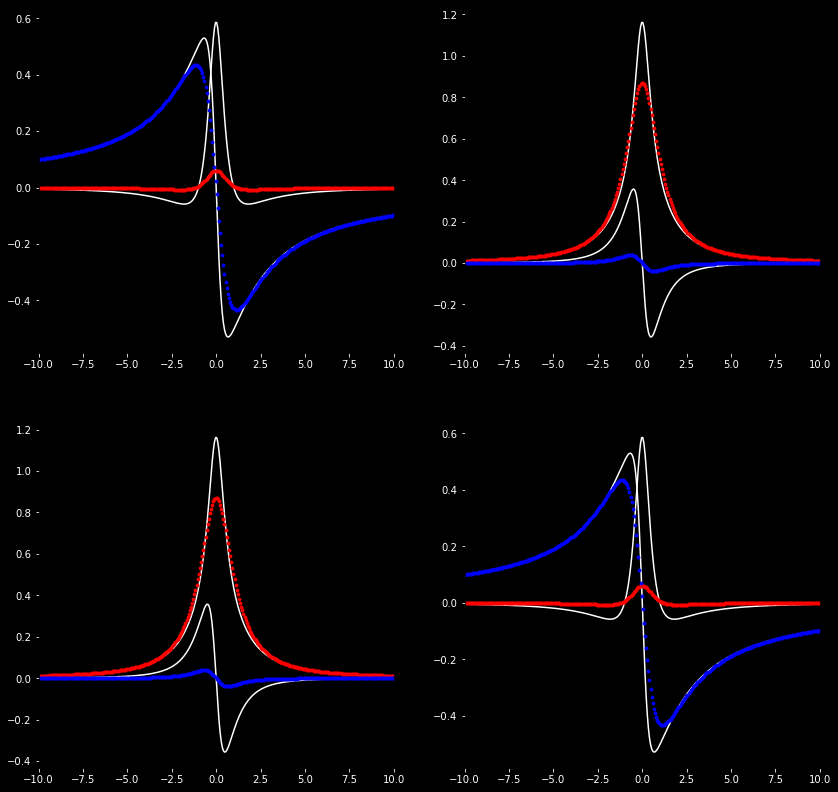

In [4]:
GWtoED(2, 2, 0.576, 100, 1 * 1024, True)